In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import cv2

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

master_path = os.path.join(os.getcwd(), '데이터SET', f"{'[Track1_데이터2] samp_train'}.csv")
master = pd.read_csv(master_path)

In [4]:
from PIL import Image
img_path = os.path.join(os.getcwd(), 'image4')

y = []
X = []

for i in range(len(master)):
    path = os.path.join(img_path, str(master.iloc[i, 0]) +'.png')
    label = master.iloc[i, 1]
    X.append(path)
    y.append(label)
        
X = np.array(X)       
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify = y)

In [5]:
test = pd.DataFrame()
test['X_test'] = X_test
test['y_test'] = y_test

train = pd.DataFrame()
train['X_train'] = X_train
train['y_train'] = y_train

train_0 = train[train['y_train'] == 0].sample(frac=1)
train_1 = train[train['y_train'] == 1].sample(frac=1)
train_2 = train[train['y_train'] == 2].sample(frac=1)
train_3 = train[train['y_train'] == 3].sample(frac=1)
train_4 = train[train['y_train'] == 4].sample(frac=1)
train_5 = train[train['y_train'] == 5].sample(frac=1)
train_6 = train[train['y_train'] == 6].sample(frac=1)
train_7 = train[train['y_train'] == 7].sample(frac=1)
train_8 = train[train['y_train'] == 8].sample(frac=1)
train_9 = train[train['y_train'] == 9].sample(frac=1)
train_10 = train[train['y_train'] == 10].sample(frac=1)

sample_size = min(len(train_0),len(train_1), len(train_2), len(train_3), len(train_4), len(train_5), len(train_6), len(train_7),
                 len(train_8), len(train_9), len(train_10))

train_f = pd.concat([train_0.head(sample_size), train_1.head(sample_size), train_2.head(sample_size), train_3.head(sample_size),
                    train_4.head(sample_size), train_5.head(sample_size), train_6.head(sample_size), train_7.head(sample_size), 
                    train_8.head(sample_size), train_9.head(sample_size), train_10.head(sample_size)]).sample(frac=1)

In [19]:
len(train_0),len(train_1), len(train_2), len(train_3), len(train_4), len(train_5), len(train_6), len(train_7),len(train_8), len(train_9), len(train_10)

(7379, 76, 13, 29, 10, 129, 499, 595, 303, 53, 25)

In [6]:
from PIL import Image
y_train = []
X_train = []

for i in range(len(train_f)):
    label = train_f.iloc[i, 1]
    img = Image.open(train_f.iloc[i, 0])
    data = np.asarray(img)
    X_train.append(data)
    y_train.append(label)
        
X_train = np.array(X_train)       
y_train = np.array(y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1, stratify = y_train)

y_test = []
X_test = []

for i in range(len(test)):
    label = test.iloc[i, 1]
    img = Image.open(test.iloc[i, 0])
    data = np.asarray(img)
    X_test.append(data)
    y_test.append(label)
        
X_test = np.array(X_test)       
y_test = np.array(y_test)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

In [7]:
img_rows, img_cols, img_channel = 331, 331, 3

base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [8]:
add_model = tf.keras.Sequential()
add_model.add(tf.keras.layers.Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(tf.keras.layers.Dropout(rate = 0.8))
#add_model.add(tf.keras.layers.Dropout(rate = 0.8))

#add_model.add(tf.keras.layers.Dropout(rate = 0.8))
add_model.add(tf.keras.layers.Dense(units=256, activation=tf.nn.relu))
add_model.add(tf.keras.layers.Dense(units=11, activation=tf.nn.softmax))

model = tf.keras.Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(lr=0.00000005),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 165, 165, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 165, 165, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 165, 165, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
batch_size = 2
epochs = 2000

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.)#,
        #rotation_range=30, 
        #width_shift_range=0.1,
        #height_shift_range=0.1, 
        #horizontal_flip=True)
train_datagen.fit(X_train)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.)#,
        #rotation_range=30, 
        #width_shift_range=0.1,
        #height_shift_range=0.1, 
        #horizontal_flip=True)
val_datagen.fit(X_val)


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=batch_size),
    callbacks=[callback]
)

# callbacks=[tf.keras.callbacks.ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 49 steps, validate for 6 steps
Epoch 1/2000
49/49 [==============================] - 19s 385ms/step - loss: 3.0085 - accuracy: 0.0825 - val_loss: 2.4195 - val_accuracy: 0.0909
Epoch 2/2000
49/49 [==============================] - 9s 178ms/step - loss: 3.1475 - accuracy: 0.0825 - val_loss: 2.3964 - val_accuracy: 0.0000e+00
Epoch 3/2000
49/49 [==============================] - 9s 179ms/step - loss: 2.9516 - accuracy: 0.0619 - val_loss: 2.5592 - val_accuracy: 0.0000e+00
Epoch 4/2000
49/49 [==============================] - 9s 178ms/step - loss: 3.0067 - accuracy: 0.1134 - val_loss: 2.5578 - val_accuracy: 0.0909
Epoch 5/2000
49/49 [==============================] - 9s 179ms/step - loss: 2.8421 - accuracy: 0.1122 - val_loss: 2.5564 - val_accuracy: 0.0909
Epoch 6/2000
49/49 [==============================] - 9s 179ms/step - loss: 3.0574 - accuracy: 0.0928 - 

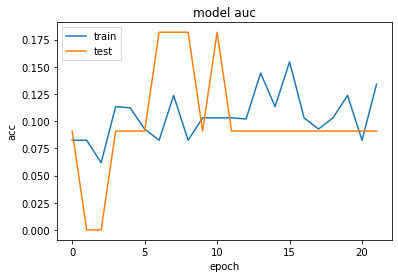

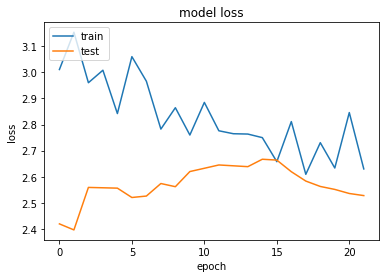

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model auc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [11]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.)#,
        #rotation_range=30, 
        #width_shift_range=0.1,
        #height_shift_range=0.1, 
        #horizontal_flip=True)
test_datagen.fit(X_test)

score = model.evaluate(test_datagen.flow(X_test, y_test, batch_size=batch_size), verbose=1)

  ...
    to  
  ['...']
507/507 [==============================] - 12s 23ms/step - loss: 2.4610 - accuracy: 0.08693s - loss: 2.4493 - accura


In [12]:
preds = model.predict(test_datagen.flow(X_test, batch_size=batch_size), verbose=1)

507/507 [==============================] - 12s 23ms/step


In [13]:
def LIFT(preds, y_test): # >=2.5
    condition = y_test.astype(bool) #preds에 정답인 예측 score만 남긴다.
    c = np.extract(condition, preds)
    b = np.argsort(-c)[:len(c)//5] #예측 score 상위 20%
    
    lift_20 = preds[b] 
    
    lift_20_flat = np.argmax(lift_20, axis=1) #값을 확률에서 0, 1값으로 바꾼다. 
    y_test_flat = np.argmax(y_test, axis=1)
    lift_20_1 = lift_20_flat[lift_20_flat == 1] #1인 경우만 남긴다. 
    y_1 = y_test_flat[y_test_flat == 1]
    
    lift_score = (len(lift_20_1)/len(lift_20_flat))/(len(y_1)/len(y_test_flat))
    print('LIFT Accuracy: ',  lift_score)
    return lift_score

In [14]:
lift_score = LIFT(preds, y_test)

LIFT Accuracy:  13.93014301430143


In [15]:
m = tf.keras.metrics.AUC()
m.update_state(y_test, preds)
auroc_score = m.result().numpy()
print(auroc_score)

0.50247806


In [16]:
final_score = (lift_score/5)*0.7 + (auroc_score)*0.3
print(final_score)

2.1009634409341613


In [17]:
#model.save('model.h5')

In [18]:
#model = tf.keras.models.load_model('model.h5')